In [11]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import swiapi
import flopy

# path to mf6 shared library
# executables based on mf6 feat-swi branch at: 
#   https://github.com/langevin-usgs/modflow6/tree/feat-swi
mf6exe = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
libmf6 = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/libmf6.dylib"


## One-Layer Steady-State Interface

### Use FloPy to Create Input Files

In [12]:
#create simple test model
Lx = 10000 # meters
delr, delc = 100., 1.
ncol = int(Lx / delr)
nlay = 1
nrow = 1
top = 50.
botm = -400.
recharge = 0.001
k = 10.
h0 = 0.
h1 = h0
icelltype = 1

ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    sim_ws=ws, 
    exe_name=mf6exe,
    memory_print_option="all"
)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
    icelltype=icelltype,
    k=k,
)
swi = flopy.mf6.ModflowGwfswi(gwf, zeta=botm)
cghb = 1. * delr * delc / 10.
ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=[[0, 0, 0, h0, cghb],
                                                       [0, 0, ncol - 1, h1, cghb]])
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
        printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
sim.write_simulation()
#sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [13]:
# head = gwf.output.head().get_data()
# bud = gwf.output.budget()
# print(head.flatten())

# spdis = bud.get_data(text='DATA-SPDIS')[0]
# qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
# pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
# pxs.plot_grid()
# pxs.plot_bc("ghb")
# pxs.plot_vector(qx, qy, qz, normalize=True, color="black")

### Run Model Using API

Initializing mf6...
Accessing pointer using tag: TDIS/DELT
Accessing pointer using tag: TDIS/NPER
Accessing pointer using tag: MYMODEL/INSTO
Accessing pointer using tag: MYMODEL/ISS
Accessing pointer using tag: MYMODEL/X
Accessing pointer using tag: MYMODEL/XOLD
Accessing pointer using tag: MYMODEL/RHS
Accessing pointer using tag: SLN_1/IA
Accessing pointer using tag: SLN_1/JA
Accessing pointer using tag: SLN_1/AMAT
Accessing pointer using tag: MYMODEL/DIS/AREA
Accessing pointer using tag: MYMODEL/DIS/TOP
Accessing pointer using tag: MYMODEL/DIS/BOT
Accessing pointer using tag: MYMODEL/NPF/SAT
Accessing pointer using tag: MYMODEL/NPF/CONDSAT
Accessing pointer using tag: MYMODEL/SWI/ZETA
Accessing pointer using tag: MYMODEL/SWI/HCOF
Accessing pointer using tag: MYMODEL/SWI/RHS
Simulation end time = 1.0...

  Solving for time 0.0
  Prepare time step with dt=[0.]...
  Prepare solve...
    Solve...(kiter=0)
           1   0.0000000000000000        0.0000000000000000     
           2   0.0

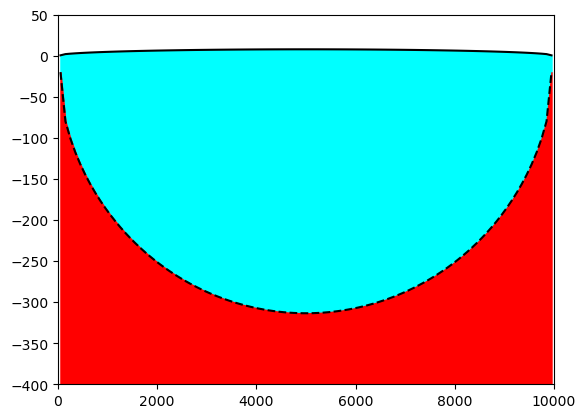

In [14]:
mf6_swi = swiapi.SwiAPi(libmf6, ws, name)
mf6_swi.run(maxiter=30)

zeta = mf6_swi.zeta_last
x = gwf.modelgrid.xcellcenters.flatten()
head = gwf.output.head().get_data().flatten()
bud = gwf.output.budget()
#print(head.flatten())
#print(zeta.flatten())

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
ax = pxs.ax
if ncol < 50:
    pxs.plot_grid()
#pxs.plot_bc("ghb")
ax.plot(x, head, "k-")
ax.plot(x, zeta, "k--")
# freshwater
ax.fill_between(x, head, zeta, color="cyan")
# saltwater
ax.fill_between(x, zeta, botm, color="red")
# pxs.plot_vector(qx, qy, qz, normalize=True, color="black")

In [15]:
fpth = pl.Path(ws) / f"{name}.dis.grb"
grb = flopy.mf6.utils.MfGrdFile(fpth)
ia = grb.ia
ja = grb.ja
nodes = grb.nodes
flowja = bud.get_data(text="FLOW-JA-FACE")[0].flatten()

# print flows bewteen cells
# for n in range(nodes):
#     for ipos in range(ia[n] + 1, ia[n + 1]):
#         m = ja[ipos]
#         q = flowja[ipos]
#         if m > n:
#             print(f"{n=} {m=} {q=}")

## One-Layer Transient Interface

### Use FloPy to Create Input Files

In [20]:
#create simple test model
Lx = 10000 # meters
delr, delc = 100., 1.
ncol = int(Lx / delr)
nlay = 1
nrow = 1
top = 50.
botm = -400.
recharge = 0.001
k = 10.
h0 = 0.
h1 = h0
icelltype = 1

ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    sim_ws=ws, 
    exe_name=mf6exe,
    memory_print_option="all"
)
nper = 1
nstp = 100
perlen = 200000.
perioddata = nper * [(perlen, nstp, 1.)]
tdis = flopy.mf6.ModflowTdis(sim, perioddata=perioddata)
ims = flopy.mf6.ModflowIms(sim, print_option="summary")
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=0.)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
    icelltype=icelltype,
    k=k,
)
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.e-5, sy=0.2)
swi = flopy.mf6.ModflowGwfswi(gwf, zeta=-1.)
cghb = 1. * delr * delc / 10.
ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=[[0, 0, 0, h0, cghb],
                                                       [0, 0, ncol - 1, h1, cghb]])
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
        printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
sim.write_simulation()
#sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package swi...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [21]:
mf6_swi = swiapi.SwiAPi(libmf6, ws, name)
mf6_swi.run(maxiter=30)

Initializing mf6...
Accessing pointer using tag: TDIS/DELT
Accessing pointer using tag: TDIS/NPER
Accessing pointer using tag: MYMODEL/INSTO
Accessing pointer using tag: MYMODEL/ISS
Accessing pointer using tag: MYMODEL/X
Accessing pointer using tag: MYMODEL/XOLD
Accessing pointer using tag: MYMODEL/RHS
Accessing pointer using tag: SLN_1/IA
Accessing pointer using tag: SLN_1/JA
Accessing pointer using tag: SLN_1/AMAT
Accessing pointer using tag: MYMODEL/DIS/AREA
Accessing pointer using tag: MYMODEL/DIS/TOP
Accessing pointer using tag: MYMODEL/DIS/BOT
Accessing pointer using tag: MYMODEL/NPF/SAT
Accessing pointer using tag: MYMODEL/NPF/CONDSAT
Accessing pointer using tag: MYMODEL/SWI/ZETA
Accessing pointer using tag: MYMODEL/SWI/HCOF
Accessing pointer using tag: MYMODEL/SWI/RHS
Accessing pointer using tag: MYMODEL/STO/SY
Simulation end time = 200000.0...

  Solving for time 0.0
  Prepare time step with dt=[0.]...
  Prepare solve...
    Solve...(kiter=0)
idx=array([ True,  True,  True,  T

In [22]:
# zeta = mf6_swi.zeta_all[1]
# x = gwf.modelgrid.xcellcenters.flatten()
# head = gwf.output.head().get_data().flatten()
# bud = gwf.output.budget()
# #print(head.flatten())
# #print(zeta.flatten())

# spdis = bud.get_data(text='DATA-SPDIS')[0]
# qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
# pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
# ax = pxs.ax
# if ncol < 50:
#     pxs.plot_grid()
# #pxs.plot_bc("ghb")
# ax.plot(x, head, "k-")
# ax.plot(x, zeta, "k--")
# # freshwater
# ax.fill_between(x, head, zeta, color="cyan")
# # saltwater
# ax.fill_between(x, zeta, botm, color="red")

In [23]:
import matplotlib.animation
x = gwf.modelgrid.xcellcenters.flatten()
zeta_all = mf6_swi.zeta_all
head_all = gwf.output.head().get_alldata()
times = gwf.output.head().times
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect(10)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
title = ax.set_title(f"Time = {times[0]} days")

# plot persistent items
pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})

def animate(i):
    global title
    zeta = zeta_all[i]
    head = head_all[i].flatten()
    ax.fill_between(x, head, zeta, color="cyan")
    # saltwater
    ax.fill_between(x, zeta, botm, color="red")
    title = ax.set_title(f"Time = {times[i]} days")

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(mf6_swi.zeta_all))
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

# can use this command to write animation to file
# ani.save("swi-trans-1lay.mp4")